# Review

In the previous notebook (`2_model-training.ipynb`), we:

1. Implemented our version of U-Net
1. Setup model training loop
1. Train the model
1. Create an inferencing pipeline
1. Make an inferencing from the trained model

That was a lot of scripting on the previous module. In this module, we will rest our finger a bit and touch our analytical side, because we are going to do some experimentation!

# Task 1: Initial Setup

## Importing Libaries

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# import subprocess

# notebook_name = '3_experiment.ipynb'
# result = subprocess.check_output(f"find /content/drive -name '{notebook_name}' 2>/dev/null", shell=True)
# notebook_path = result.decode('utf-8').strip()

# # Check if a path was found
# if notebook_path:
#     print(f"Found notebook at: {notebook_path}")
# else:
#     print("Notebook not found")
import os
notebook_path = os.path.join(os.getcwd())

In [3]:
%%capture
!pip install rasterio

In [4]:
import os
import sys
from pathlib import Path

# Import from your package
sys.path.append(str(Path(notebook_path).parent))
from app.data_setup import BuildingsDroneDataset, create_dataloaders

## Preparing Directories

In [5]:
NB_DIR = Path(notebook_path)
PROJECT_DIR = NB_DIR.parent

DATA_DIR = os.path.join(PROJECT_DIR ,"nb", 'data')
print(f"Data directory: {DATA_DIR}")
RAW_DATA_DIR = os.path.join(DATA_DIR,'0_raw')
INTERIM_DATA_DIR = os.path.join(DATA_DIR, '1_interim')
PATCH_DIR = os.path.join(DATA_DIR , '2_patches')
print(f"Project directory: {PROJECT_DIR}")
folder_list = [
    DATA_DIR,
    RAW_DATA_DIR,
    INTERIM_DATA_DIR,
    PATCH_DIR,
]

for folder in folder_list:
    if not os.path.exists(folder):
        os.makedirs(folder)

RANDOM_SEED = 42

Data directory: /home/akm/Work/Compu/Drone-Image-DL-Classification/nb/data
Project directory: /home/akm/Work/Compu/Drone-Image-DL-Classification


## Requirements

In this module, we will use MLFlow to track our experiments. If you are running it locally, everything is set for you. However, if you run it in google colab, you need to have an auth key from [**ngrok**](https://ngrok.com/).

1. Visit this website<br>
https://ngrok.com/
2. You can sign up using your email, then sign in.

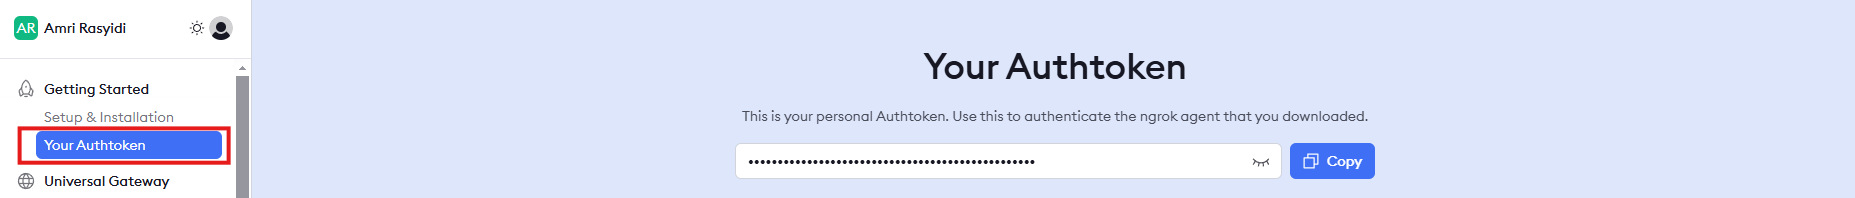

In [6]:
from IPython import display
display.Image(os.path.join(PROJECT_DIR,'app','img','6_ngrok.png'))

3. After that, navigate to the "Your Authtoken" page
4. Copy your authtoken
5. Put it in the cell below inside the " ".

In [7]:
ngrok_auth = "2w1BaaLxXberIIWJTPdBIGBUDC5_5fEbaS1fVwWpgaYSceA8E" ## pyani account (test)

**NOTE: THIS IS NOT A GOOD PRACTICE OF STORING CREDENTIAL SUCH AS AUTH TOKEN.<br>
But for practicality, we will do it this way anyway.**

**Reset Token**<br>
Once you finish with this module, you should go back to the "Your Authtoken" page in ngrok dashboard, scroll down, and click "Reset Authtoken" to ensure your token is safe.

## Bringing DataLoader From Previous Notebook

In [8]:
# Create dataset with augmentation and preprocessing
dataset = BuildingsDroneDataset(
    patch_dir=os.path.join(PATCH_DIR,'patch'),
    label_dir=os.path.join(PATCH_DIR,'label'),
)

In [9]:
# Create dataloaders
train_loader, val_loader = create_dataloaders(
    patch_dir=os.path.join(PATCH_DIR,'patch'),
    label_dir=os.path.join(PATCH_DIR,'label'),
    batch_size=2,
    num_workers=1
)

# Introduction to Experimentation in Deep Learning

Deep learning models are powerful but their performance depends heavily on the choices we make when setting up and training them. In this module, we'll explore the process of experimenting with our UNet model for drone image segmentation.

## Why experiment with hyperparameters?

Hyperparameters are the "knobs" we can turn to control how our model learns. Unlike model parameters (weights and biases) which are learned during training, hyperparameters must be set before training begins. They include:

- Learning rate
- Optimizer choice
- Batch size
- Model architecture (depth, width)
- Loss function
- Regularization techniques

Each deep learning task is unique, and there's rarely a one-size-fits-all configuration that works optimally for every problem. Finding the right hyperparameters often makes the difference between a model that performs poorly and one that achieves state-of-the-art results.

## The impact of hyperparameters on model performance

Hyperparameters can dramatically influence:
- **Training stability**: Too high learning rates can cause training to diverge, while too low rates can make training painfully slow.
- **Generalization ability**: The right hyperparameters help the model learn meaningful patterns without overfitting to training data.
- **Convergence speed**: Good hyperparameter choices can help models reach optimal performance in fewer training epochs.
- **Final performance metrics**: The difference between average and excellent performance often comes down to hyperparameter tuning.

For semantic segmentation tasks like ours, even small improvements in metrics like IoU or Dice score can translate to significantly better real-world performance in identifying buildings from drone imagery.

## Common pitfalls in deep learning experimentation

When experimenting with deep learning models, watch out for these common issues:
- **Poor experiment tracking**: Forgetting which configurations you've tried or what results they produced
- **Changing multiple hyperparameters at once**: Makes it impossible to know which change was responsible for performance differences
- **Overfitting to the validation set**: Making too many decisions based on validation performance can lead to indirect overfitting
- **Ignoring computational constraints**: Some experiments might be theoretically interesting but practically infeasible
- **Confirmation bias**: Tendency to focus on experiments that confirm our expectations

## Different ways to track machine learning experiments
There are as many different ways to track machine learning experiments as there are experiments to run.

This table covers a few.

| Method                                     | Setup                                      | Pros                                                                         | Cons                                                                     | Cost                  |
|--------------------------------------------|--------------------------------------------|------------------------------------------------------------------------------|--------------------------------------------------------------------------|-----------------------|
| Python dictionaries, CSV files, print outs | None                                       | Easy to setup, runs in pure Python                                           | Hard to keep track of large numbers of experiments                       | Free                  |
| [TensorBoard](https://www.tensorflow.org/tensorboard/get_started)                                | Minimal, install [tensorboard](https://pypi.org/project/tensorboard/)               | Extensions built into PyTorch, widely recognized and used, easily scales.    | User-experience not as nice as other options.                            | Free                  |
| [Weights & Biases Experiment Tracking](https://wandb.ai/site/experiment-tracking)       | Minimal, install [wandb](https://docs.wandb.ai/quickstart), make an account    | Incredible user experience, make experiments public, tracks almost anything. | Requires external resource outside of PyTorch.                           | Free for personal use |
| [MLFlow](https://mlflow.org/)                                     | Minimal, install mlflow and start tracking | Fully open-source MLOps lifecycle management, many integrations.             | Little bit harder to setup a remote tracking server than other services. | Free                  |

Taken from [learnpytorch.io](https://www.learnpytorch.io/07_pytorch_experiment_tracking/)

## Setting up clear experimental goals

Before we start experimenting, let's define what we're trying to achieve:
- Primary goal: Understand how different optimizers (Adam vs. SGD) and learning rates affect our UNet model's performance on drone image segmentation
- Success metrics: We'll measure:
    - Validation Dice score
    - Validation IoU
    - Training convergence speed
- Experimental approach: We'll use **MLflow** to:
    - Track multiple training runs with different configurations
    - Compare performance across runs
    - Visualize training dynamics
    - Make data-driven decisions about model configuration

# Introduction to MLFlow

## What is MLFlow and why use it?
MLFlow is an open-source platform designed to manage the machine learning lifecycle, including experimentation, reproducibility, deployment, and a model registry. It was created to address the challenge of keeping track of experiments and managing models in ML projects.

When working on deep learning projects, we often run dozens or even hundreds of experiments with different hyperparameters, model architectures, and data preprocessing techniques. Without a proper tracking system, it's easy to lose track of what we've tried and which configurations performed best.

MLFlow solves this problem by providing a centralized system to:
- Track experiments and compare results
- Package code and models for reproducible runs
- Share and deploy models
- Manage model versions in a central repository

## Key components of MLFlow
MLFlow consists of four main components:
1. MLFlow Tracking: Records and queries experiments, including code, data, configurations, and results
    - Logs parameters, metrics, and artifacts for each experiment run
    - Provides visualizations to compare runs
    - Can be used locally or on a central server
1. MLFlow Projects: Packages ML code in a reusable, reproducible form
    - Standardizes how to run ML code
    - Defines dependencies and entry points
1. MLFlow Models: Package ML models in a standard format for deployment
    - Makes it easy to move models to production
    - Supports multiple "flavors" to deploy to different platforms
1. Model Registry: Centralized model store to collaboratively manage model lifecycle
    - Tracks model lineage and versions
    - Handles transitions between stages (staging, production, etc.)

For our experimentation with UNet, **we'll primarily use MLFlow Tracking to log and compare our different training runs** with various optimizers and learning rates.

## MLFlow Tracking: Automatic vs. Manual
MLFlow provides two main approaches to tracking experiments:
- Manual tracking - Explicitly calling mlflow.log_param(), mlflow.log_metric(), and other logging functions in your code
- Automatic tracking - Using integrations with frameworks that automatically log parameters and metrics

When using manual tracking, you need to explicitly log everything you want to track:

```python
import mlflow

with mlflow.start_run():
    mlflow.log_param("learning_rate", 0.001)
    mlflow.log_metric("accuracy", 0.85)
    # ... train model ...
    mlflow.pytorch.log_model(model, "model")
```

While this approach gives you complete control, it requires more code and can be error-prone if you forget to log important information.

## From PyTorch to PyTorch Lightning
In our previous module, we implemented the UNet architecture and training loop using pure PyTorch. This gave us complete control over the implementation details, but required us to manually handle training loops, device management, metric tracking, and more.

[PyTorch Lightning](https://lightning.ai/docs/pytorch/stable/) is a lightweight wrapper around PyTorch that organizes PyTorch code to make it more maintainable while removing much of the boilerplate code associated with training deep learning models. It preserves the flexibility of PyTorch while providing a more structured approach to model development.

Converting a PyTorch model to Lightning typically involves:
1. Organizing code into a `LightningModule` class
1. Moving the training, validation, and testing steps into specific methods
1. Setting up configuration for optimizers and learning rate schedulers

While this conversion process is valuable to learn, it's beyond the scope of our current module which focuses on experimentation. For your convenience, a Lightning implementation of our UNet model (`LightningUNet`) has already been created so we can focus on the experimentation aspects.

## PyTorch Lightning and MLFlow Integration
PyTorch Lightning provides seamless integration with MLFlow through its logging system. When using a Lightning model with the MLFlow logger, many things are tracked automatically:
- Model hyperparameters
- Training and validation metrics at each epoch
- Learning rate changes
- System information

This automatic tracking significantly reduces the amount of code we need to write and ensures consistent logging across experiments.

Lightning handles this integration through the MLFlowLogger class, which we'll use to track our UNet experiments with different optimizers and learning rates.

```python
from lightning.pytorch.loggers import MLFlowLogger

# Create a logger instance
logger = MLFlowLogger(experiment_name="unet_segmentation", run_name="adam_lr_0.001")

# Create a trainer with the logger
trainer = L.Trainer(logger=logger, ...)

# Train the model - metrics are logged automatically
trainer.fit(model, train_dataloader, val_dataloader)
```

With this integration, we can focus on defining our experiments rather than worrying about the mechanics of tracking them.

Now that we understand how Lightning and MLFlow work together, let's set up our experiments to compare different optimizers and learning rates for our UNet model.

# Task 2: Designing Experiments for UNet Semantic Segmentation

## Identifying key hyperparameters to experiment with
For learning purpose, we'll focus on two critical hyperparameters:
- Optimizer type: Adam vs. SGD
- Learning rate: Different values for each optimizer

We choose only these metrics combination since training a deep learning model can take a while.

## Metrics to track for semantic segmentation tasks
We'll track these key metrics:

- Loss: Training and validation loss
- Dice Coefficient: Measures overlap between predicted and ground truth masks
- IoU (Intersection over Union): Another measure of segmentation quality

## Implementing our experiment function

In [10]:
# This install might take a while (3-5 minutes), this library is quite large

# %%capture
!pip install lightning

In [11]:
import torch
import lightning as L
from lightning.pytorch.callbacks import EarlyStopping
from lightning.pytorch.loggers.mlflow import MLFlowLogger

# Import our Lightning UNet model
from app.unet_model import UNet
from app.lightning_unet import LightningUNet

In [12]:
# Define the MLflow tracking URI
MLFLOW_TRACKING_URI = NB_DIR/'mlruns'
print(f"MLflow tracking URI: {MLFLOW_TRACKING_URI}")

MLflow tracking URI: /home/akm/Work/Compu/Drone-Image-DL-Classification/nb/mlruns


NOTE: In Experment tracking, using Early stops in experiements tracking is not practical, the practical choice would be to train for a fixed small number of epochs and compare final metrics. We will continue this code as it's useful for learning purpose.

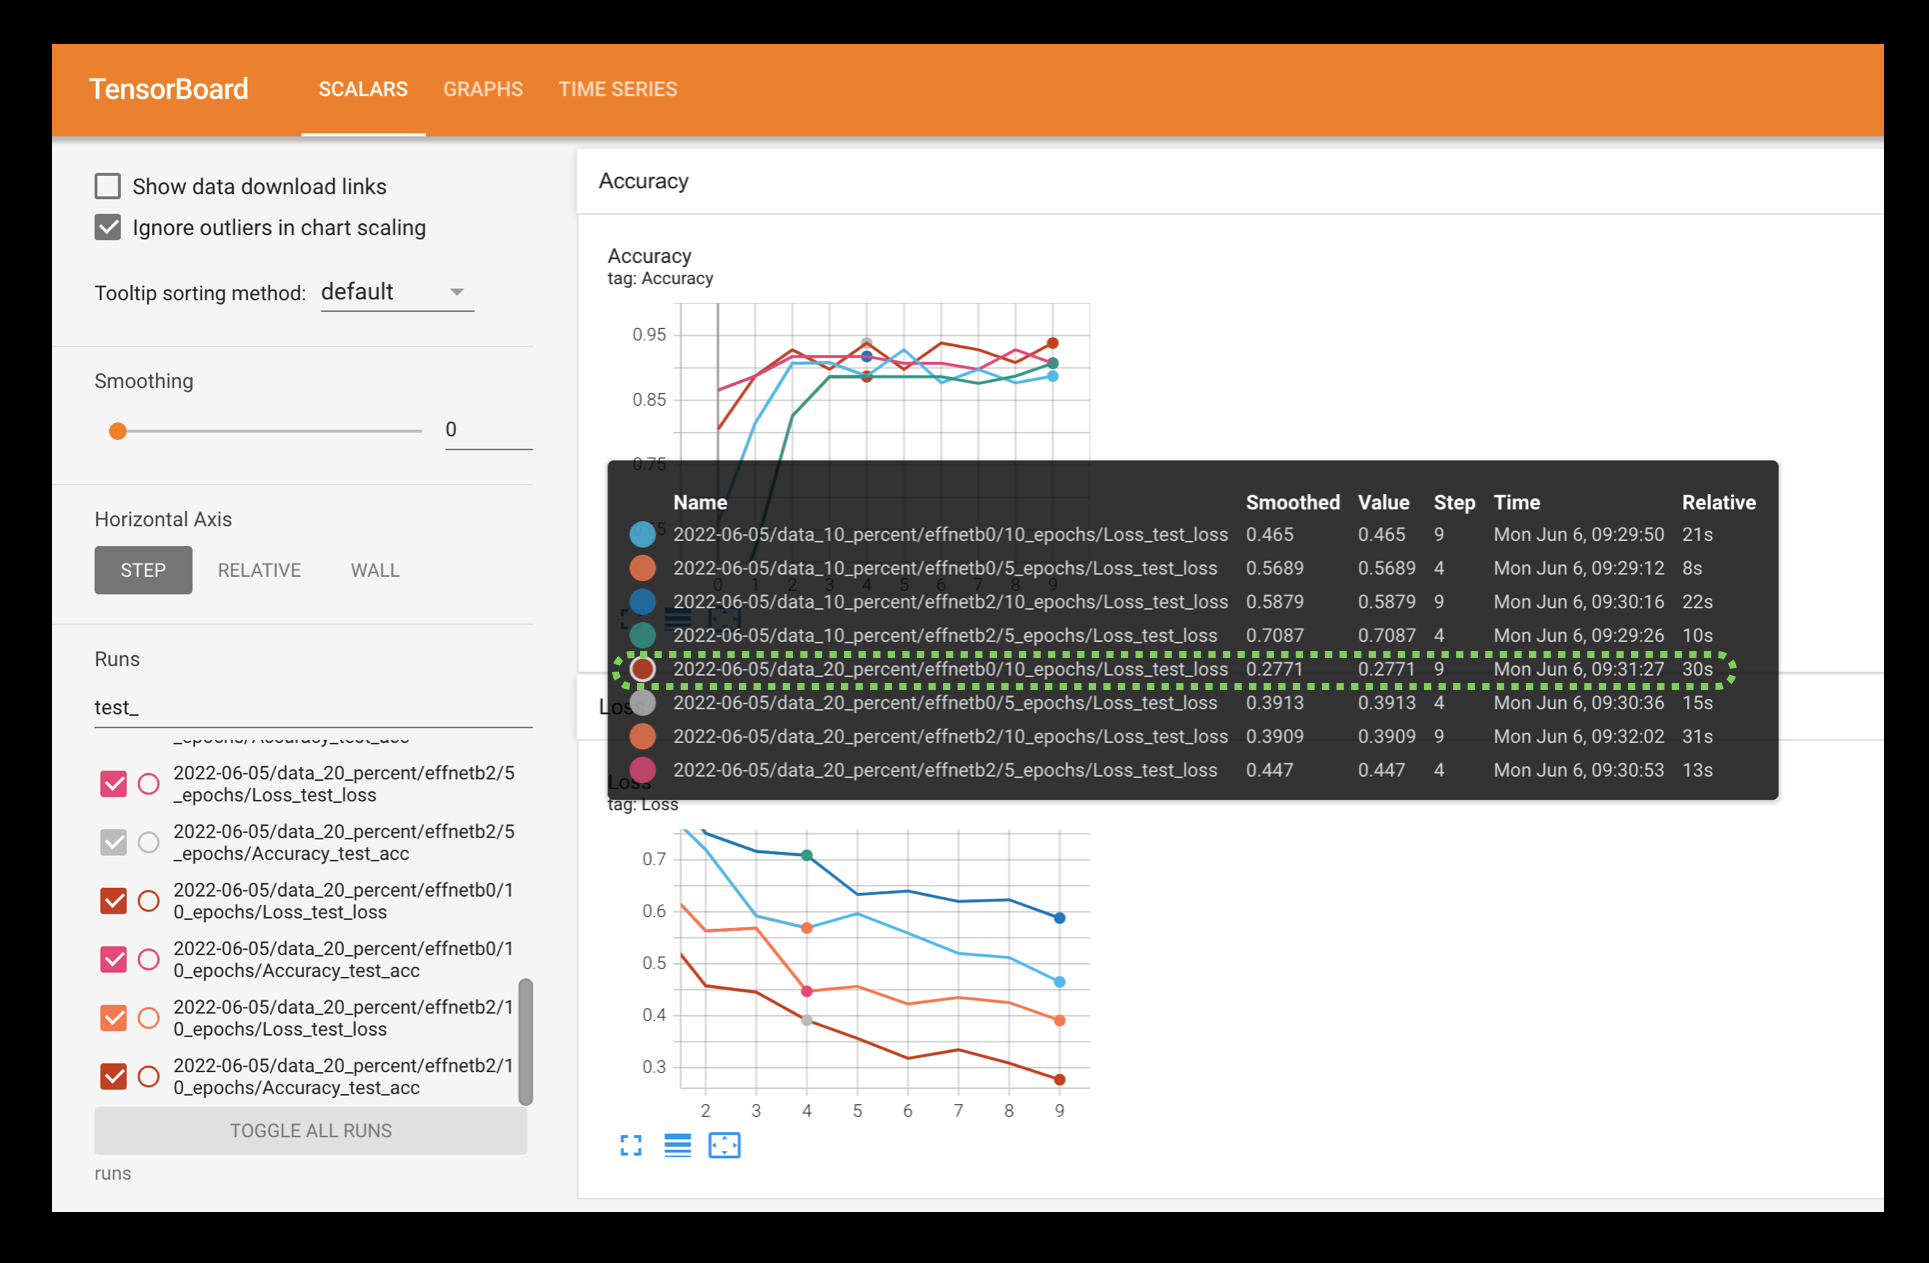

In [ ]:
import gc
import mlflow

ARTIFACTS_DIR = MLFLOW_TRACKING_URI/'artifacts'
os.makedirs(ARTIFACTS_DIR, exist_ok=True)
print(f"Artifacts directory: {ARTIFACTS_DIR}")
def run_experiment(optimizer_type='adam', learning_rate=0.001, max_epochs=2):
    """Train UNet with specific optimizer and learning rate, tracking with MLFlow"""
    if 'model' in locals():
        del model
        torch.cuda.empty_cache()
        gc.collect()
    run_name = f"{optimizer_type}_lr_{learning_rate}".replace('.', '_')
    with mlflow.start_run():
        # Create run name and MLflow logger
        

        # Log hyperparameters
        mlflow.log_params({
            "optimizer_type": optimizer_type,
            "learning_rate": learning_rate
        })

        # Early stopping callback
        early_stop_callback = EarlyStopping( #NOTE: Using Early stops in experiements tracking is not practical, the practical
            monitor="val_loss", patience=3, mode="min"
        )
        

        # Create model with specified learning rate
        model = LightningUNet(in_channels=3, out_channels=1, learning_rate=learning_rate)

        # Modify optimizer if using SGD
        if optimizer_type.lower() == 'sgd':
            def configure_optimizers(self):
                optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate, momentum=0.9)
                scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                    optimizer, mode='min', factor=0.1, patience=5,
                )
                return {
                    "optimizer": optimizer,
                    "lr_scheduler": {"scheduler": scheduler, "monitor": "val_loss", "frequency": 1},
                }
            import types
            model.configure_optimizers = types.MethodType(configure_optimizers, model)

        # Setup trainer and train
        trainer = L.Trainer(
            max_epochs=max_epochs,
            accelerator="gpu" if torch.cuda.is_available() else "cpu",
            devices=1,
            callbacks=[early_stop_callback],
            log_every_n_steps=10,
            # model_registry=str(ARTIFACTS_DIR),
        )
        # Train and evaluate
        trainer.fit(model, train_loader, val_loader)
        val_results = trainer.validate(model, val_loader)
        model_info = mlflow.pytorch.log_model(model, name=run_name)
        print(f"Model saved in run {mlflow.active_run().info.run_id} with info: {model_info}")
    return {
            "optimizer_type": optimizer_type,
            "learning_rate": learning_rate,
            "val_loss": val_results[0]["val_loss"],
            "val_dice": val_results[0]["val_dice"],
            "val_iou": val_results[0]["val_iou"]
        }

Artifacts directory: /home/akm/Work/Compu/Drone-Image-DL-Classification/nb/mlruns/artifacts


# Task 3: Setting Up MLFlow UI for Experiment Tracking

Before we run our experiments, let's set up the MLFlow UI so we can monitor our runs in real-time and analyze the results afterward.

## Setting up the MLFlow UI
MLFlow provides a web-based user interface that allows us to visualize, compare, and analyze our experiment runs. Let's start by launching the MLFlow UI:

In [30]:
%%capture
!pip install mlflow -q
!pip install pyngrok -q

In [31]:
import mlflow
import subprocess
from pyngrok import ngrok, conf

In [32]:
# Start the MLflow server using subprocess
subprocess.Popen(["mlflow", "ui", "--backend-store-uri", str(MLFLOW_TRACKING_URI), "--port", "5000"])

<Popen: returncode: None args: ['mlflow', 'ui', '--backend-store-uri', '/hom...>

In [ ]:
# Set MLflow tracking URI
mlflow.set_tracking_uri(str(MLFLOW_TRACKING_URI))
mlflow.set_experiment("building_segmentation_tuning")

In [34]:
# Set up ngrok for exposing the MLflow UI
conf.get_default().auth_token = ngrok_auth

In [35]:
# Expose the MLflow UI on port 5000
port = 5000
public_url = ngrok.connect(port).public_url
print("Click the link below with 'ngrok-free.app' below, then click 'Visit Site' to visit the MLFlow UI")
print(f' * ngrok tunnel "{public_url}" -> "http://127.0.0.1:{port}"')

Click the link below with 'ngrok-free.app' below, then click 'Visit Site' to visit the MLFlow UI
 * ngrok tunnel "https://45756334470f.ngrok-free.app" -> "http://127.0.0.1:5000"


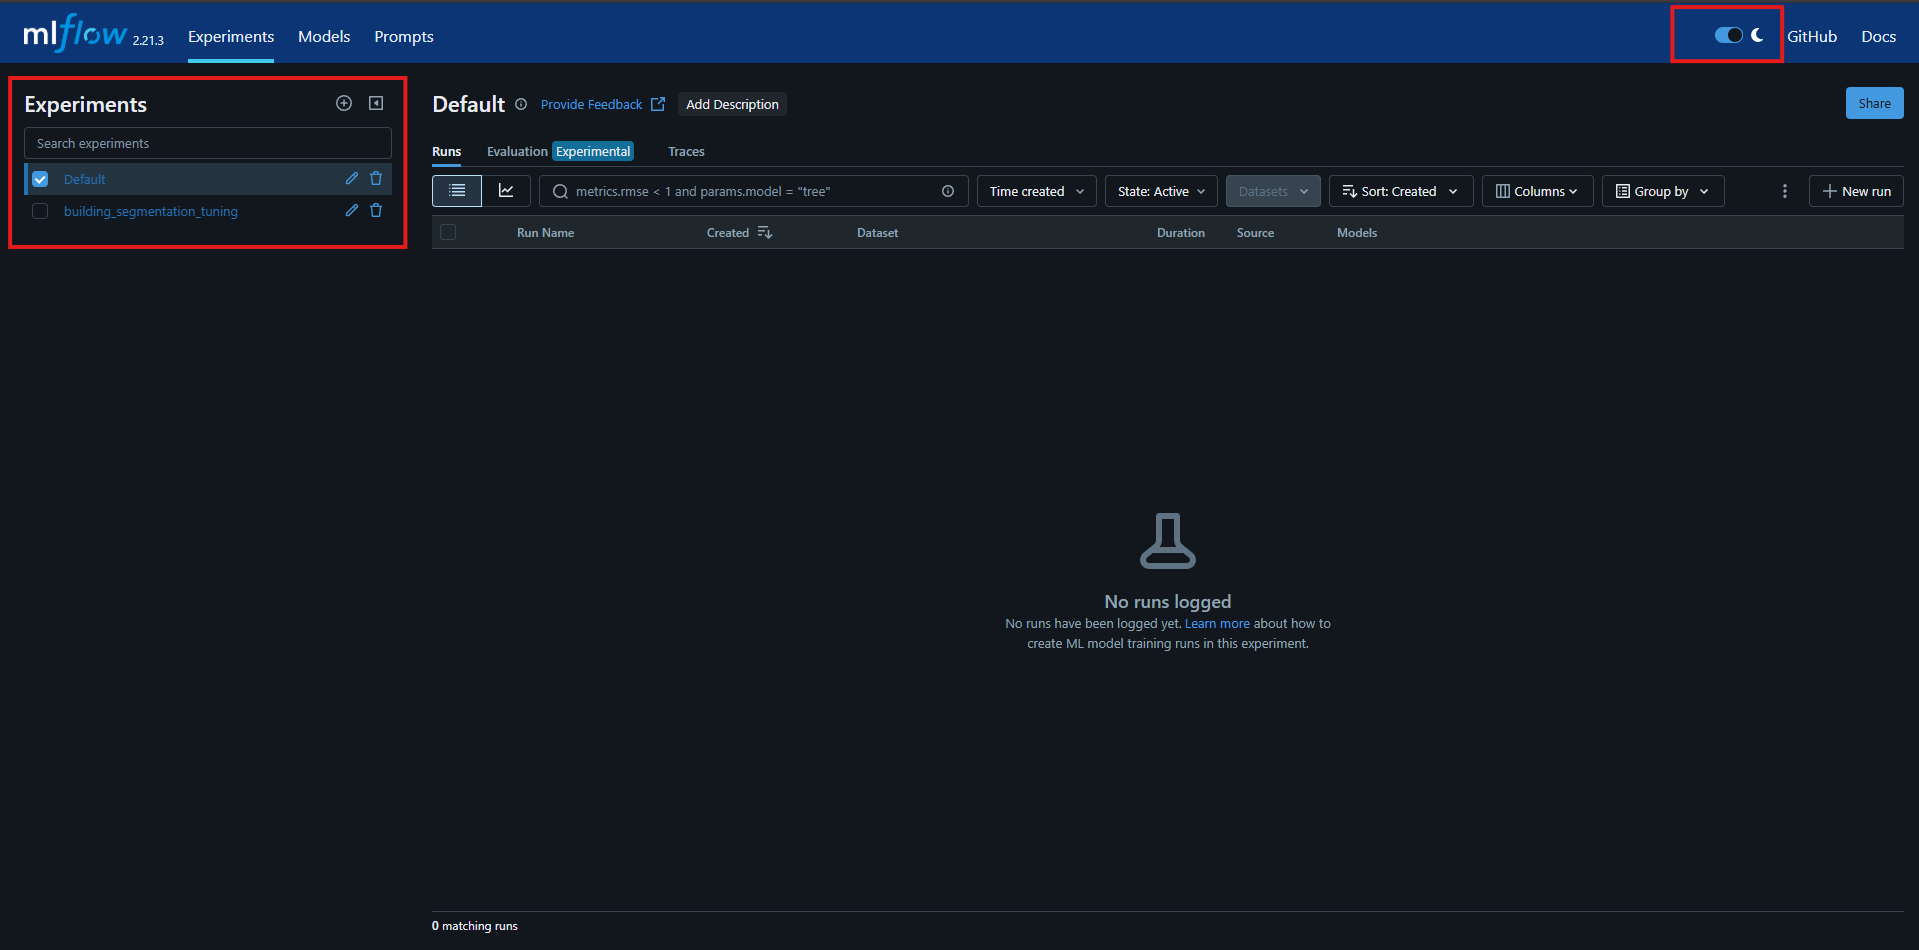

In [36]:
display.Image(os.path.join(PROJECT_DIR,'app','img','0_mlflow_homepage.png'))

<figure style="text-align: center">
  <i>Homepage of MLFlow. Yours might seems a bit different.<br>
  On the top-left side, you can access different experiments. On the top-right side, you can toggle dark/light mode.
  </i>
</figure>

# Task 5: Analyzing Results with MLFlow UI

Running an experiment, especially for deep learning, is resource consumptive. If you are running this module in google colab, free version, you most likely run into crashing kernel. That is why we have prepared with you some successful run so you can still explore MLFlow UI.

**By default we won't run the experiment.**

If you still would like to try running the experiment, you can still do it by scrolling down to the bottom of the module, there is a ready-to-run cell to start the experiment.

Now that our experiments are complete, let's explore how to analyze the results using the MLFlow UI.

## Navigating the MLFlow UI

### Experiment View:

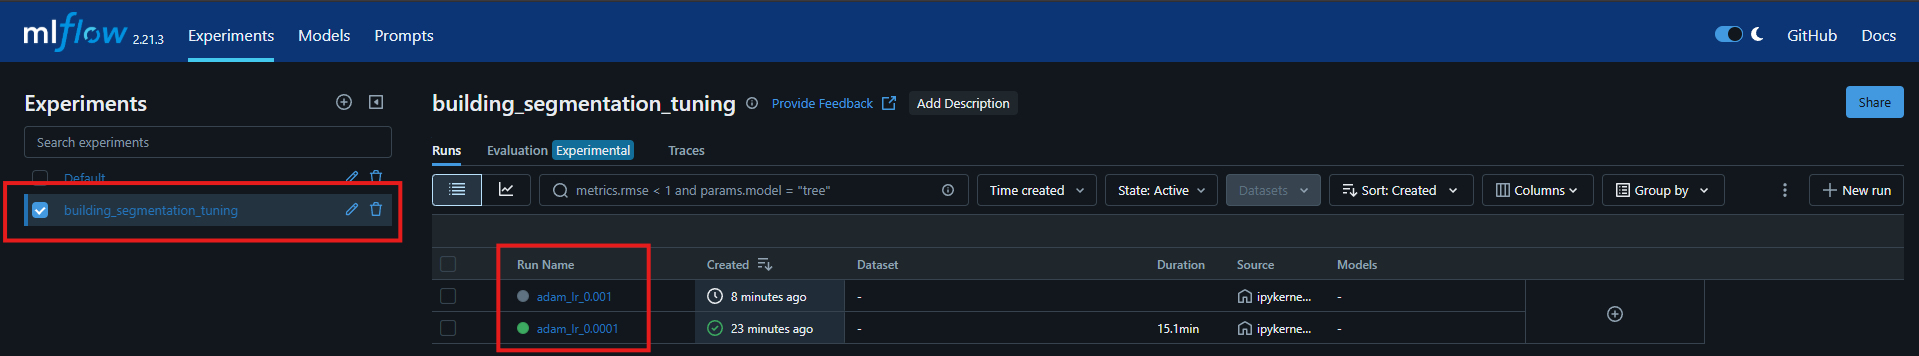

In [37]:
display.Image(os.path.join(PROJECT_DIR,'app','img','1_mlflow_experimenthome.png'))

- Click on the "building_segmentation_tuning" experiment to see all runs
- Each run represents a different optimizer/learning rate combination
- The runs are named according to the configuration (e.g., "adam_lr_0.001")

### Comparing Runs:


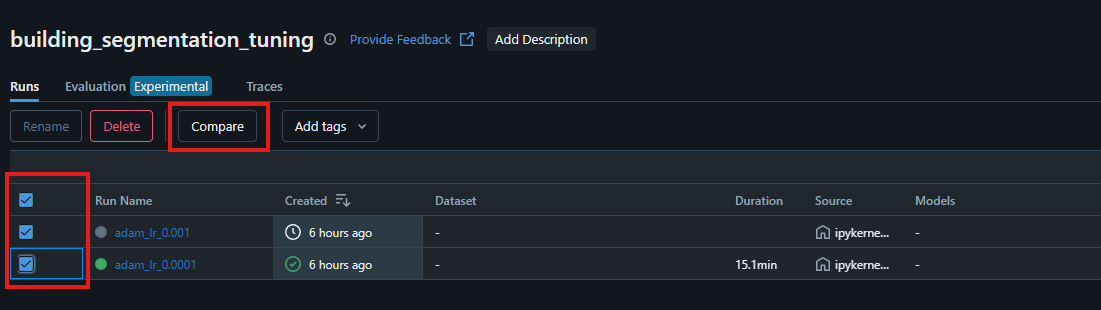

In [38]:
display.Image(os.path.join(PROJECT_DIR,'app','img','2_compare_start.png'))

- Select the checkbox next to each run you want to compare
- Use the "Compare" button to compare runs


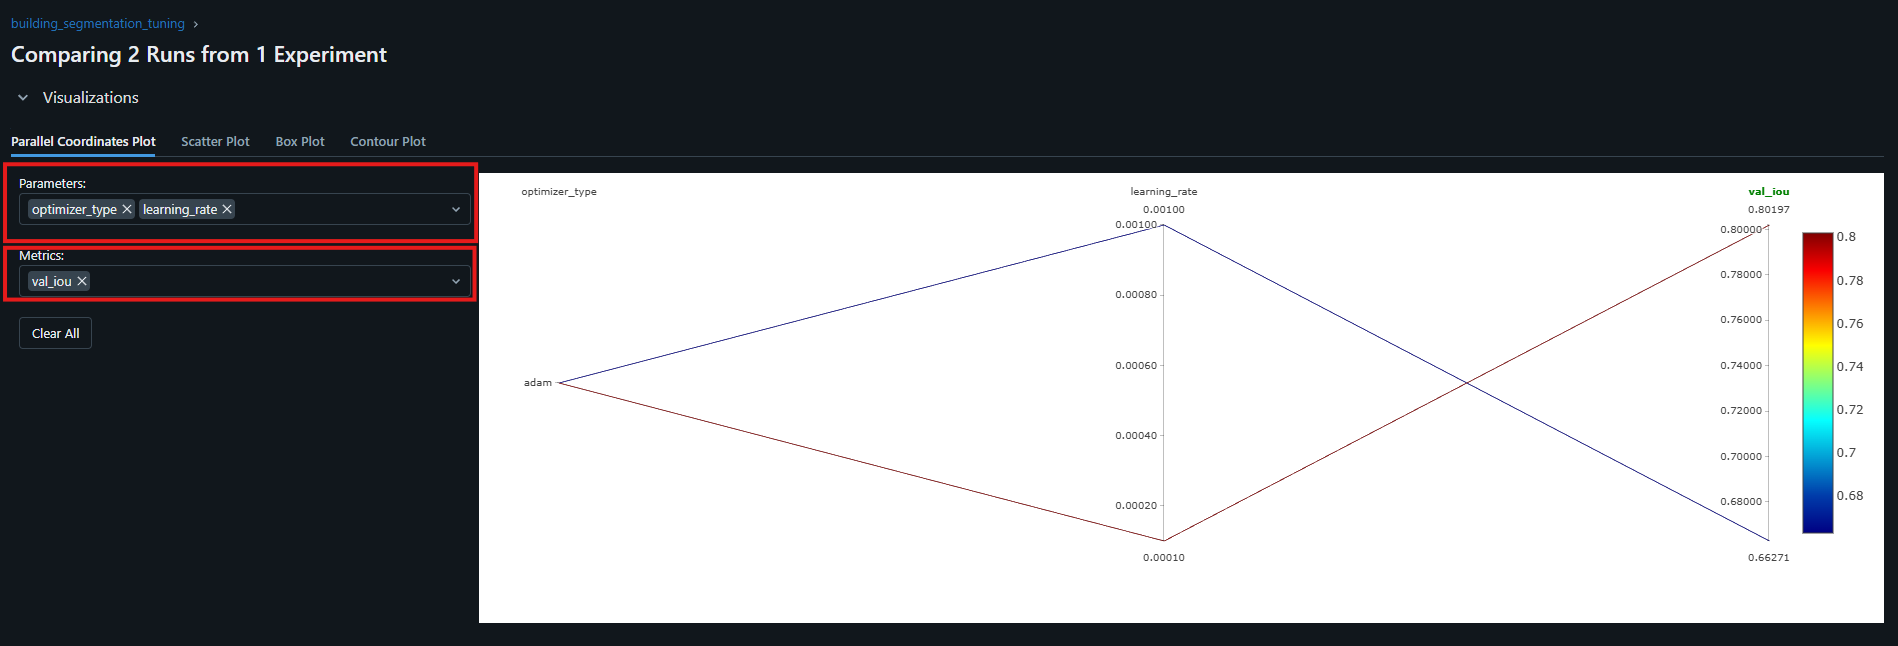

ERROR:    [Errno 98] Address already in use
Running the mlflow server failed. Please see the logs above for details.


In [39]:
display.Image(os.path.join(PROJECT_DIR,'app','img','3_compare.png'))

- In the `Parameters` form, fill in `optimizer_type` and `learning_rate`
- In the `Metrics` form, let's assume our most important metrics is `val_iou`
- Then you can analyze how different combinations of `Parameters` we run previously lead to different result in `Metrics`

### Exploring Metrics:

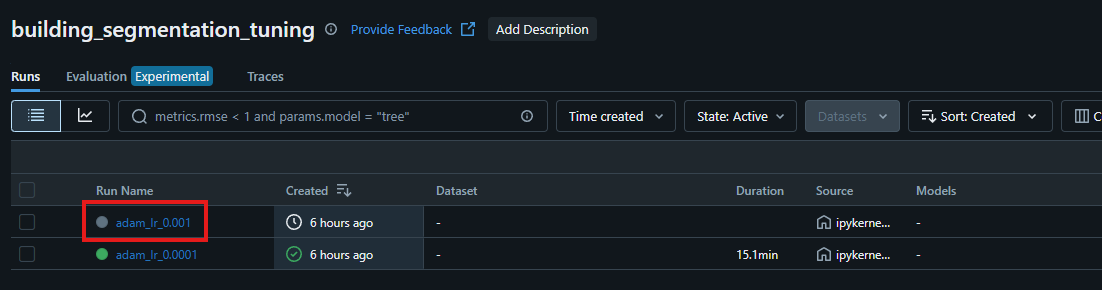

In [40]:
display.Image(os.path.join(PROJECT_DIR,'app','img','4_individual.png'))

- Click on any individual run to see detailed information

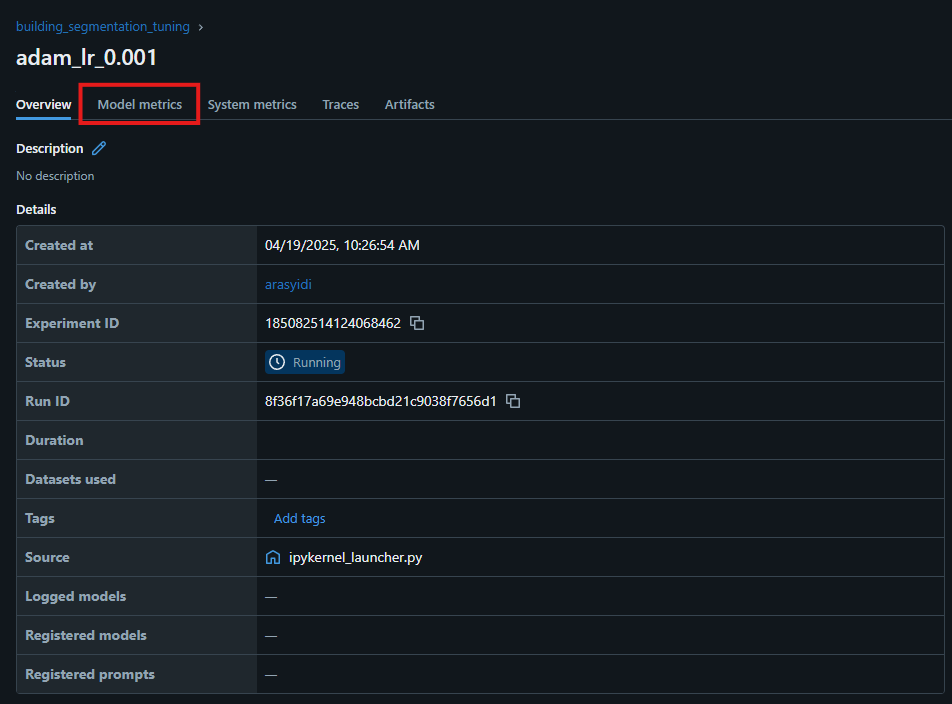

In [41]:
display.Image(os.path.join(PROJECT_DIR,'app','img','5_individual_overview.png'))

- You can read the `Overview` tab to see the overview of this run
- Navigate to the `Model Metrics` tab to see training and validation metrics
- Click on any metric to see its evolution over time

<div class="alert alert-block alert-success">
<h3>Excercise 1</h3>
Key Questions to Answer
</div>
Use the MLFlow UI to answer these questions based on your experiment result:

1. Which optimizer generally performed better, Adam or SGD?
1. What learning rate worked best for each optimizer?
1. How did the validation loss change over time for different configurations?
1. Did any runs show signs of overfitting (training loss decreasing while validation loss increases)?
1. Which configuration achieved the highest Dice score and IoU?

<details>
<summary>Click to see answer.</summary>

There's no _one_ correct answer for this one ;)

</details>

By exploring these questions through the MLFlow UI, you'll gain insights not just about which configuration performed best, but also about how different optimizers and learning rates affect the training dynamics of UNet models for semantic segmentation.

# 🎉 Congratulations on Completing the Module! 🎉

Well done! You've successfully completed the experimentation module for UNet semantic segmentation using MLFlow. This module has taken you through the essential process of hyperparameter experimentation and tracking your deep learning experiments.

Here's a summary of what we accomplished in this module:

1. **Understanding Experimentation in Deep Learning**
   - Learned the importance of hyperparameter tuning
   - Explored how hyperparameters impact model performance
   - Identified common pitfalls in experimentation
   - Set clear experimental goals for our segmentation task
1. **MLFlow Integration**
   - Set up MLFlow for experiment tracking
   - Learned how PyTorch Lightning integrates with MLFlow
   - Created a structured approach to log parameters and metrics
   - Used the MLFlow UI to visualize experiment results
1. **Structured Experimentation Plan**
   - Systematically tested different optimizer types (Adam vs SGD)
   - Experimented with various learning rates
   - Tracked key segmentation metrics (loss, Dice score, IoU)
   - Analyzed how different configurations affect performance
1. **Results Analysis**
   - Compared experiment results across different runs
   - Visualized training dynamics for different configurations

This experimentation process is a crucial skill for deep learning practitioners, allowing you to systematically improve model performance beyond the initial implementation. You now have the tools to approach any deep learning problem with a structured experimental mindset, tracking your progress and making data-driven decisions about model configurations.

# Further Reading

- YouTube Video - [Cornell CS 5787: Applied Machine Learning. Lecture 22. Part 1: Learning Curves](https://youtu.be/lYAV5KNk_TY?si=JHM_iQ7ol03e0xy_)
- YouTube Video - [Cornell CS 5787: Applied Machine Learning. Lecture 22. Part 2: Loss Curves](https://youtu.be/StNrJnL8eX0?si=yhvwLyXswdHst7E0)
- YouTube Video - [Cornell CS 5787: Applied Machine Learning. Lecture 22. Part 3: Validation Curves](https://youtu.be/wCBuc6Qc_wI?si=WgS0BPB_6b7umRsy)

# [OPTIONAL] Task 4: Run The Experiment!

After designing the experiment and setting up the MLFlow UI, we can finally run the experiment! This will take a while, since we are not running only one training but multiple! Four of them to be exact.

In [42]:
# this cell is meant to be error as a gate keeper to prevent unintentionally running the cells below (experiment part)
error will happen here

SyntaxError: invalid syntax (229536384.py, line 2)

## Creating a structured experimental plan

We'll use a simple grid of experiments:

In [43]:
# Define our experiment configurations
experiment_configs = [
    # Adam optimizer experiments
    {'optimizer_type': 'adam', 'learning_rate': 0.0001},
    {'optimizer_type': 'adam', 'learning_rate': 0.001},

    # SGD optimizer experiments
    {'optimizer_type': 'sgd', 'learning_rate': 0.0001},
    {'optimizer_type': 'sgd', 'learning_rate': 0.001},
]

In [44]:
import gc

def empty_cache():#To avoid GPU memory issues
    gc.collect()
    torch.cuda.empty_cache()
# Run all experiments defined in our configuration grid
results = []

# We'll use fewer epochs for demonstration purposes
max_epochs = 2
empty_cache() #To avoid GPU memory issues
print("Starting experiments...")
for config in experiment_configs:
    optimizer_type = config['optimizer_type']
    learning_rate = config['learning_rate']

    print(f"\nRunning experiment with {optimizer_type} optimizer, learning rate = {learning_rate}")

    # Run the experiment and collect results
    result = run_experiment(
        optimizer_type=optimizer_type,
        learning_rate=learning_rate,
        max_epochs=max_epochs
    )
    empty_cache() #To avoid GPU memory issues
    # Store results for summary
    results.append(result)

    # # Display key metrics
    # print(f"Results: val_loss={result['val_loss']:.4f}, val_dice={result['val_dice']:.4f}, val_iou={result['val_iou']:.4f}")

print("\nAll experiments completed!")

Traceback (most recent call last):
  File "/home/akm/Work/virt-env/general/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 366, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/akm/Work/virt-env/general/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 464, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/akm/Work/virt-env/general/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 1634, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/akm/Work/virt-env/general/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 1627, in _read_helper
    result = read_yaml(root,

Starting experiments...

Running experiment with adam optimizer, learning rate = 0.0001


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type               | Params | Mode 
-----------------------------------------------------------
0 | unet        | UNet               | 31.0 M | train
1 | criterion   | BCEWithLogitsLoss  | 0      | train
2 | dice_metric | DiceScore          | 0      | train
3 | iou_metric  | BinaryJaccardIndex | 0      | train
4 | train_dice  | DiceScore          | 0      | train
5 | val_dice    | DiceScore          | 0      | train
6 | test_dice   | DiceScore          | 0      | train
7 | train_iou   | BinaryJaccardIndex | 0      | train
8 | val_iou     | BinaryJaccardIndex | 0      | train
9 | test_iou    | BinaryJaccardIndex | 0      | train
-----------------------------------------------------------
31.0 M    Trainable params
0         Non-trainable params
31.0 M    Total params
124.174   Total estimated model params size (M

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/akm/Work/virt-env/general/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


OutOfMemoryError: CUDA out of memory. Tried to allocate 128.00 MiB. GPU 0 has a total capacity of 3.68 GiB of which 116.88 MiB is free. Process 45619 has 1.38 GiB memory in use. Including non-PyTorch memory, this process has 2.15 GiB memory in use. Of the allocated memory 2.06 GiB is allocated by PyTorch, and 10.42 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
results

In [ ]:
print(f"MLflow tracking URI: {MLFLOW_TRACKING_URI}")